<h1>
<center>Empirical Asset Pricing via Machine Learning</center>
</h1>



<center>Alexander Margetis, Lanya Ma, Sheng Yang, Yiming Tan</center>



## 1. Introduction



In this project, we conducted an empirical analysis of machine learning methods in asset pricing. We aim to measure and predict risk premium with bundles of underlying factors. In particular, we attempt to study the structure of cross-sectional returns by using various factors. These factors can be stock-level firm characteristics, macroeconomic descriptors and many other derived indicators. In the empirical literature, classical models are proposed to estimate and explain the risk premia with several factors, like CAPM, Fama-French 3 factor and later Fama-French 5 factor model. These models are basically linear projection from bahavior of stocks' expected returns to multiple variates. As the high-dimensional nature is innate in machine learning methods, we can enhances the flexibility of representing assets risk profile relative to more traditional econometric prediction techniques.And the functionals which project high-dimensional predictors to risk premia can be complicated. That's why the application of machine learning in this field can be rather attractive.   

Our major contributions in this project are three-fold. First, we investigate machine learning techniques in prediction of cross-sectional returns. This tells us whether machine learning algorithms can improve the estimation of out-of-sample expected returns. Second, we examine the feature importance of factors.This process gives us insights that how to select informative factors. Third, we study the stability of machine learning in portfolio constrcution. We analyze the performance of long-short portfolio from the algorithms over the horizon.

## 2. Methodology

Our dataset in this project includes all listed firms in the NYSE, AMEX, and NASDAQ. Our sample begins in January 2009 to April 2019. Our data is monthly updated. We use the Treasury-bill rate as risk-free rate for calculating the excessive returns. The firms characteristics or the factors in other words, include firms' value, growth, solvency, cash flow, profitability, operating capacity, capital structure and momentum. In addition, we include the categorical industry classes corresponding to GICS sectors.    

### 2.1 Data Preprocessing and Exploratory Data Analysis (Lanya Ma and Yiming Tan)

Data Cleaning (Lanya Ma)

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import pickle

os.chdir(os.getcwd() + '\\data')
extension = 'csv'
result = glob.glob('*.{}'.format(extension))
print(result)
data_name_list = list(map(lambda x: x[:-4] , result)) 

['3m_tbill_rate.csv', 'bps.csv', 'ca_to_assets.csv', 'current.csv', 'debt_over_asset.csv', 'ebitda_to_sales.csv', 'eps_ttm.csv', 'equity_to_totalcap.csv', 'GICS_code.csv', 'market_cap.csv', 'netprofit_margin.csv', 'ocf_ps.csv', 'ocf_to_debt.csv', 'ocf_to_sales.csv', 'op_to_debt.csv', 'pb.csv', 'pe_ttm.csv', 'price.csv', 'ps_ttm.csv', 'roa.csv', 'roe.csv', 'roic.csv', 'sales_growth1yr.csv', 'tax_to_ebt.csv', 'turnover.csv']


In [4]:
import copy
import numpy as np

def transform_row(filename):
    raw_df = pd.read_csv(filename)
    row_names = raw_df.iloc[:,0]
    raw_df = raw_df.rename(index = row_names)
    new_df = raw_df.drop(raw_df.columns[0],axis = 1)
    return new_df

#Omit stocks w/ no price
price = transform_row('price.csv')
sum_df = pd.DataFrame(price.sum(axis = 1)).reset_index()
valid = sum_df[sum_df[0]!=0].index.values

price_v = price.iloc[valid,:]
is_available = copy.deepcopy(price_v)
is_available[:] = np.nan
is_available[price_v != 0] = 1
price_df = price_v*is_available


def tranfrom_missing(filename):
    raw =  transform_row(filename)
    raw = raw.iloc[valid,:]
    nrow = raw.shape[0]
    ncol = raw.shape[1]
    raw = raw.applymap(lambda x: float(x))
    raw_mat = np.asmatrix(raw)
    for i in range(0,nrow):
        fill_data = 0
        for j in range(0,ncol):
            if raw_mat[i,j] != 0:
                fill_data = raw_mat[i,j]
            else:
                raw_mat[i,j] = fill_data
    filled_df = pd.DataFrame(raw_mat)
    filled_df.index = price_v.index.values
    filled_df.columns = price_v.columns.values
    filled_df = np.multiply(filled_df,is_available)
    filled_df[filled_df == 0] = np.nan
    return filled_df


sector_code = transform_row('GICS_code.csv')
sector_code[sector_code ==0] = np.nan
"""
sector_intcode = []
for code in sector_code['GICS_Code']:
    if ~np.isnan(code):
        code = int(code)
    sector_intcode.append(code)
"""

# Consider S&P Dow Jones Indices and MSCI changed sector classification
sector_dict = {1010:"Energy", 1510:"Materials",2010:"Capital Goods", 2020:"Commercial & Professional Services",
               2030:"Transportation", 2510:"Automobiles & Components", 2520:"Consumer Durables & Apparel",
               2530:"Consumer Services", 2540:"Media & Entertainment", 2550:"Retailing", 3010:"Food & Staples Retailing",
               3020:"Food, Beverage & Tobacco", 3030:"Household & Personal Products", 3510:"Health Care Equipment & Services",
               3520:"Pharmaceuticals, Biotechnology & Life Sciences", 4010:"Banks", 4020:"Diversified Financials",
               4030:"Insurance", 4040:"Real Estate",4510:"Software & Services", 4520:"Technology Hardware & Equipment",
               4530:"Semiconductors & Semiconductor Equipment", 5010:"Telecommunication Services", 5020:"Media & Entertainment",
               5510:"Utilities", 6010:"Real Estate"}    

sectors_list = []
for code in sector_code['GICS_Code']:
    if ~np.isnan(code):
        code = sector_dict[code]
    sectors_list.append(code)

In [5]:
features_dict = {}
numeric_features = []
for idx, element in enumerate(result):
    feature_name = data_name_list[idx]
    if feature_name not in ['3m_tbill_rate','GICS_code','price']:
        feature_df = tranfrom_missing(element)
        features_dict[data_name_list[idx]] = feature_df
        numeric_features.append(feature_name)

In [6]:
#Stock return
return_mon = (price_df - price_df.T.shift(1).T)/price_df.T.shift(1).T
# shift the next month return ahead so that we can concatenate features and target
return_mon = return_mon.T.shift(-1).T
#Risk free rate
rf= transform_row('3m_tbill_rate.csv')
rfree = rf['rate'][return_mon.columns.values]/12

In [7]:
#Raw Data Dictionary
data_dict = {}
time_keys = price.columns.values
first_feature = list(features_dict.keys())[0]
sectors_array = np.array(sectors_list).reshape(-1, 1)
sectors_array = sectors_array[valid]
for time_key in time_keys[:-1]:
    cat_array = features_dict[first_feature][time_key].values.reshape(-1, 1)
    for key in list(features_dict.keys())[1:]:
        right_array = features_dict[key][time_key].values.reshape(-1, 1)
        cat_array = np.concatenate((cat_array,right_array),axis = 1)
    y_array = return_mon[time_key].values.reshape(-1,1)-rfree[time_key]
    cat_array = np.concatenate((cat_array,sectors_array),axis = 1)
    data_array = np.concatenate((cat_array,y_array),axis = 1)
    data_df = pd.DataFrame(data_array)
    data_df.index = price_df.index.values
    data_df.columns = list(features_dict.keys()) + ['Sectors'] + ['Excess_return']
    data_dict[time_key] = data_df

In [6]:
import pickle
with open('factordata.p', 'wb') as fp:
    pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
with open('factordata.p', 'rb') as fp:
    factordata = pickle.load(fp)

Build data pipeline(Yiming Tan)

In [13]:
def valid_return(dataframe):
    # will raise error with object type in nparray
    
    nrow = data_df.shape[0]
    for i in range(0,nrow):
        if not np.isnan(dataframe['Excess_return'][i]):
            exist.append(i)
    dat = dataframe.iloc[exist,:]
    return dat

def valid_returnV2(dataframe):
    dataframe['Excess_return'] = dataframe['Excess_return'].astype(float)
    # exclude rows where Excess_return is nan
    dat = dataframe[np.isfinite(dataframe['Excess_return'])]
    return dat

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

num_pipeline = Pipeline([
        ('imp', IterativeImputer(max_iter=10, random_state=0,estimator = KNeighborsRegressor(n_neighbors=15))),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
        ('one', OneHotEncoder(categories='auto')),
    ])


X = {}
y = {}

In [14]:
# fill missing sector with most_frequent item
cat_counts = np.unique(sectors_array, return_counts=True)
most_freq_sec = cat_counts[0][np.argmax(cat_counts[1])]
sectors_array[sectors_array == 'nan'] = most_freq_sec
set(sectors_array.ravel())

{'Automobiles & Components',
 'Banks',
 'Capital Goods',
 'Commercial & Professional Services',
 'Consumer Durables & Apparel',
 'Consumer Services',
 'Diversified Financials',
 'Energy',
 'Food & Staples Retailing',
 'Food, Beverage & Tobacco',
 'Health Care Equipment & Services',
 'Household & Personal Products',
 'Insurance',
 'Materials',
 'Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences',
 'Real Estate',
 'Retailing',
 'Semiconductors & Semiconductor Equipment',
 'Software & Services',
 'Technology Hardware & Equipment',
 'Telecommunication Services',
 'Transportation',
 'Utilities'}

In [15]:
onehotencoder = OneHotEncoder(categories='auto')
encoded_array = onehotencoder.fit_transform(sectors_array.reshape(-1,1)).toarray()
dummy_names = onehotencoder.get_feature_names().astype(str)
dummy_names = list(map(lambda x: x[3:] , dummy_names))

In [16]:
for time_key in time_keys[:-1]:
    raw_df = data_dict[time_key].drop('Sectors', axis=1)
    complete_array = np.concatenate((raw_df,encoded_array),axis=1)
    complete_df = pd.DataFrame(complete_array)
    whole_col_names = numeric_features + ['Excess_return'] + dummy_names
    complete_df.index = raw_df.index.values
    complete_df.columns = whole_col_names
    dat = valid_returnV2(complete_df)
    num_features = dat.drop('Excess_return',axis=1).iloc[:,:len(numeric_features)]
    cat_features = dat.iloc[:, len(numeric_features)+1:]
    num_features_ = num_pipeline.fit_transform(num_features)
    X_array = np.concatenate((num_features_,cat_features),axis=1)
    X[time_key] = pd.DataFrame(X_array)
    X[time_key].index = dat.index.values
    X[time_key].columns = numeric_features + dummy_names
    y[time_key] = pd.DataFrame(dat['Excess_return'])
    y[time_key].index = dat.index.values

In [80]:
with open('XData.p', 'wb') as xp:
    pickle.dump(X, xp, protocol=pickle.HIGHEST_PROTOCOL)
with open('yData.p', 'wb') as yp:
    pickle.dump(y, yp, protocol=pickle.HIGHEST_PROTOCOL)    

In [16]:
Train = {}
Test = {}
for time_key in time_keys[:100]:
    Train[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)
for time_key in time_keys[100:-1]:
    Test[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)

In [13]:
with open('cleanTrain.p', 'wb') as gp:
    pickle.dump(Train, gp, protocol=pickle.HIGHEST_PROTOCOL)
with open('cleanTest.p', 'wb') as hp:
    pickle.dump(Test, hp, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('XData.p', 'rb') as xp:
    X = pickle.load(xp)
with open('yData.p', 'rb') as yp:
    y = pickle.load(yp)

In [8]:
# convert dictionary to dataframe
X_train = X[time_keys[0]]
y_train = y[time_keys[0]]
X_val = X[time_keys[80]]
y_val = y[time_keys[80]]
X_test = X[time_keys[100]]
y_test = y[time_keys[100]]
for time_key in time_keys[1:80]:
    X_train = pd.concat([X_train,X[time_key]])
    y_train = pd.concat([y_train,y[time_key]])
for time_key in time_keys[81:100]:   
    X_val = pd.concat([X_val,X[time_key]])
    y_val = pd.concat([y_val,y[time_key]])    
for time_key in time_keys[101:-1]:
    X_test = pd.concat([X_test,X[time_key]])
    y_test = pd.concat([y_test,y[time_key]])
X_train_full = pd.concat([X_train,X_val])
y_train_full = pd.concat([y_train,y_val])

Here is a preview of our dataset

In [40]:
X_train_full.head().T

,A.N,AA.N,AABA.O,AAME.O,AAN.N
bps,-0.0385709,-0.028816,-0.0381268,-0.0409029,-0.0371933
ca_to_assets,-0.228212,-0.0735075,-0.699517,0.605843,0.52249
current,-0.0693796,-0.141201,-0.0122894,-0.122099,-0.00237525
debt_over_asset,0.533349,0.360067,-1.71713,0.157742,0.104414
ebitda_to_sales,0.0760933,0.0747886,0.0764966,0.0984245,0.0504457
eps_ttm,-0.0196061,-0.0351406,-0.0241428,-0.0259118,-0.0232729
equity_to_totalcap,-0.157934,-0.138001,0.244494,-0.14398,-0.095018
market_cap,0.0362597,-0.11183,0.47785,-0.174813,-0.14524
netprofit_margin,0.0825359,0.0794078,0.0793144,0.0610338,0.0563832
ocf_ps,-0.0397209,-0.0365995,-0.0405728,-0.0415079,-0.0401645


### 2.2 Generalized linear models (by Alexander Margetis)


In [81]:
#ElaticNet
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
ypred = elastic_net.predict(X_test)
mean_squared_error(y_test, ypred)

0.2069940043398497

In [84]:
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
from sklearn.model_selection import GridSearchCV
parametersGrid = {"max_iter": [1, 5, 10],
                    "alpha": [0.001, 0.01, 0.1],
                    "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='r2', cv=10,n_jobs=-1)

In [85]:
grid.fit(X_train, y_train)
Y_pred = grid.predict(X_test)

In [86]:
mean_squared_error(y_test, Y_pred)

0.2069943668962153

### 2.3 Support vector machines (by Alexander Margetis)


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[:30000])
X_train_scaled = scaler.transform(X_train[:30000])
scaler.fit(y_train[:30000])
y_train_scaled = scaler.transform(y_train[:30000])

In [10]:
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
regressor.fit(X_train_scaled, y_train_scaled)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

0.20955069843751387

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {'kernel': ['sigmoid', 'linear', 'poly'],"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42,n_jobs=-2)
rnd_search_cv.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  25 out of  30 | elapsed:  2.0min remaining:   23.5s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000285536CD668>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028551C5C470>,
                                        'kernel': ['sigmoid', 'linear',
                                                   'poly']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [15]:
rnd_search_cv.best_estimator_

SVR(C=4.998609717152554, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.001239742034078414, kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
Y_pred = rnd_search_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, Y_pred)

0.21117959678660966

### 2.4 Ensemble Learning (by Sheng Yang)

We applied the features (e.g. 0-46) of the current month to predict the excessive return of next month. Append the excessive return of next month to the features of the current month. 

#### 2.4.1 Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, n_jobs=-2,
                                max_features=7, random_state=42)
rf_reg.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
# test MSE
print(mean_squared_error(y_test, rf_reg.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, rf_reg.predict(X_test))) 

0.2342031092569485
0.1974527031673029


Grid search for best hyperparameters in random forest:

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 50 (2×5×5) combinations of hyperparameters
    {'bootstrap': [False, True], 'n_estimators': [10, 50, 100, 200, 500], 'max_features': [3, 6, 12, 24, 46]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of 18*5=90 rounds of training 
forest_reg_grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-2)

forest_reg_grid_search.fit(X_train.head(10000), y_train.head(10000))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid=[{'bootstrap': [False, True],
      

In [23]:
forest_reg_grid_search.best_params_

{'bootstrap': True, 'max_features': 6, 'n_estimators': 100}

In [24]:
forest_reg_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [25]:
best_rf_reg= forest_reg_grid_search.best_estimator_
best_rf_reg.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [26]:
# test MSE
print(mean_squared_error(y_test, best_rf_reg.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, best_rf_reg.predict(X_test))) 

0.2105864003881391
0.17346189546556126


#### 2.4.3 Extra Trees

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

extratrees = ExtraTreesRegressor(bootstrap=True, n_estimators=200, max_features=7,
                                  n_jobs=-2, random_state=42)

In [28]:
extratrees.fit(X_train_full, y_train_full)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
                    max_features=7, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-2,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

In [29]:
# test MSE
print(mean_squared_error(y_test, extratrees.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, extratrees.predict(X_test))) 

0.2060187802793624
0.16473142320243508


#### 2.4.4 Adaboost 

In [30]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=50,
                         learning_rate=0.25, random_state=42)

In [31]:
ada.fit(X_train_full, y_train_full)

AdaBoostRegressor(base_estimator=None, learning_rate=0.25, loss='linear',
                  n_estimators=50, random_state=42)

In [32]:
# test MSE
print(mean_squared_error(y_test, ada.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, ada.predict(X_test))) 

0.4870475655874892
0.19700830939749836


#### 2.4.5 Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(max_depth=3,
                                n_estimators=100,
                                learning_rate=0.1,
                                random_state=42)

In [34]:
gb.fit(X_train_full, y_train_full)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
# test MSE
print(mean_squared_error(y_test, gb.predict(X_test)))
# test MAE
print(mean_absolute_error(y_test, gb.predict(X_test))) 

0.2451435046948259
0.17326740753435643


#### 2.4.6 Xgboost

In [36]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)

In [38]:
xgb.fit(np.array(X_train), np.array(y_train),
        eval_set=[(np.array(X_val), np.array(y_val))],
        early_stopping_rounds=10)

[03:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.934863
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.914279
[2]	validation_0-rmse:0.897284
[3]	validation_0-rmse:0.883077
[4]	validation_0-rmse:0.871592
[5]	validation_0-rmse:0.862547
[6]	validation_0-rmse:0.854692
[7]	validation_0-rmse:0.848447
[8]	validation_0-rmse:0.843547
[9]	validation_0-rmse:0.839529
[10]	validation_0-rmse:0.836267
[11]	validation_0-rmse:0.833809
[12]	validation_0-rmse:0.831841
[13]	validation_0-rmse:0.829905
[14]	validation_0-rmse:0.828827
[15]	validation_0-rmse:0.827952
[16]	validation_0-rmse:0.826958
[17]	validation_0-rmse:0.826564
[18]	validation_0-rmse:0.825758
[19]	validation_0-rmse:0.825088
[20]	validation_0-rmse:0.824641
[21]	validation_0-rmse:0.824339
[22]	validation_0-rmse:0.823922
[23]	validation_0-rmse:0.82418
[24]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
# test MSE
print(mean_squared_error(np.array(y_test), xgb.predict(np.array(X_test))))
# test MAE
print(mean_absolute_error(np.array(y_test), xgb.predict(np.array(X_test))))

0.21028913568972432
0.18694667263539025


#### 2.4.7 Stacking Ensemble Method

Stacking ensemble method: Use the predictions from random forest, extra trees, Adaboost, Gradient boosting
<br> as features and the actual label of the observations as the target. 

In [40]:
from sklearn.model_selection import cross_val_predict

models = [best_rf_reg, extratrees, ada, gb]
model_names = ["forest", "ExtraTrees", "AdaBoost", "GradientBoost"]

In [41]:
pred = []
for idx, m_ in enumerate(models):
    pred.append(cross_val_predict(m_, X_train_full, y_train_full,
                                  cv=3))
    print(model_names[idx])
pred=np.transpose(np.array(pred))

forest
ExtraTrees
AdaBoost
GradientBoost


In [42]:
blender = RandomForestRegressor(n_estimators=100,
                                 n_jobs=-1, random_state=42)

%time blender.fit(pred, y_train_full)

Wall time: 42.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [43]:
pred_test = []
for idx, m_ in enumerate(models):
    pred_test.append(m_.predict(X_test))
    print(model_names[idx])
pred_test = np.transpose(np.array(pred_test))

forest
ExtraTrees
AdaBoost
GradientBoost


In [44]:
# test MSE
print(mean_squared_error(y_test, blender.predict(pred_test)))
# test MAE
print(mean_absolute_error(y_test, blender.predict(pred_test)))

0.2980508098259408
0.19502167199382606


#### 2.4.8 Variable importance of different tree methods:

In [45]:
models = [best_rf_reg, extratrees, ada, gb, xgb]
model_names = ["random forest", "ExtraTrees", "AdaBoost", "GradientBoost", "Xgboost"]

importances = []
for idx, m_ in enumerate(models):
    importances.append(m_.feature_importances_)
    print(model_names[idx])
importances = np.transpose(np.array(importances))

random forest
ExtraTrees
AdaBoost
GradientBoost
Xgboost


In [50]:
importances=pd.DataFrame(importances, index=X_train.columns.values,columns=model_names)
importances

,random forest,ExtraTrees,AdaBoost,GradientBoost,Xgboost
bps,0.033053,0.035664,0.000000e+00,0.001463,0.015180
ca_to_assets,0.020158,0.056596,1.716094e-12,0.000989,0.004635
current,0.036036,0.038052,0.000000e+00,0.000082,0.000000
debt_over_asset,0.029938,0.052409,3.863977e-03,0.137229,0.003779
ebitda_to_sales,0.020470,0.043259,0.000000e+00,0.001110,0.000624
eps_ttm,0.039390,0.032025,1.523378e-07,0.095183,0.102161
equity_to_totalcap,0.037901,0.049430,0.000000e+00,0.028455,0.000000
market_cap,0.047178,0.048862,2.462580e-09,0.019025,0.000959
netprofit_margin,0.026389,0.055833,0.000000e+00,0.002029,0.002760
ocf_ps,0.018890,0.038090,6.486371e-09,0.001221,0.001361


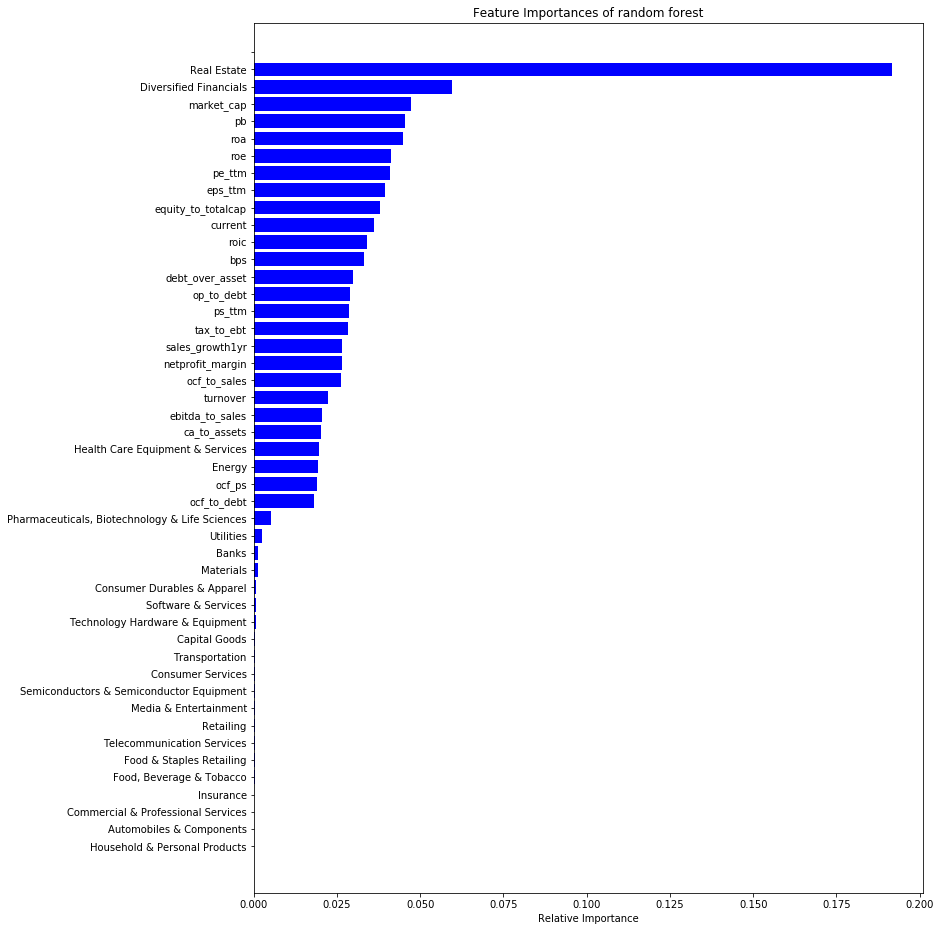

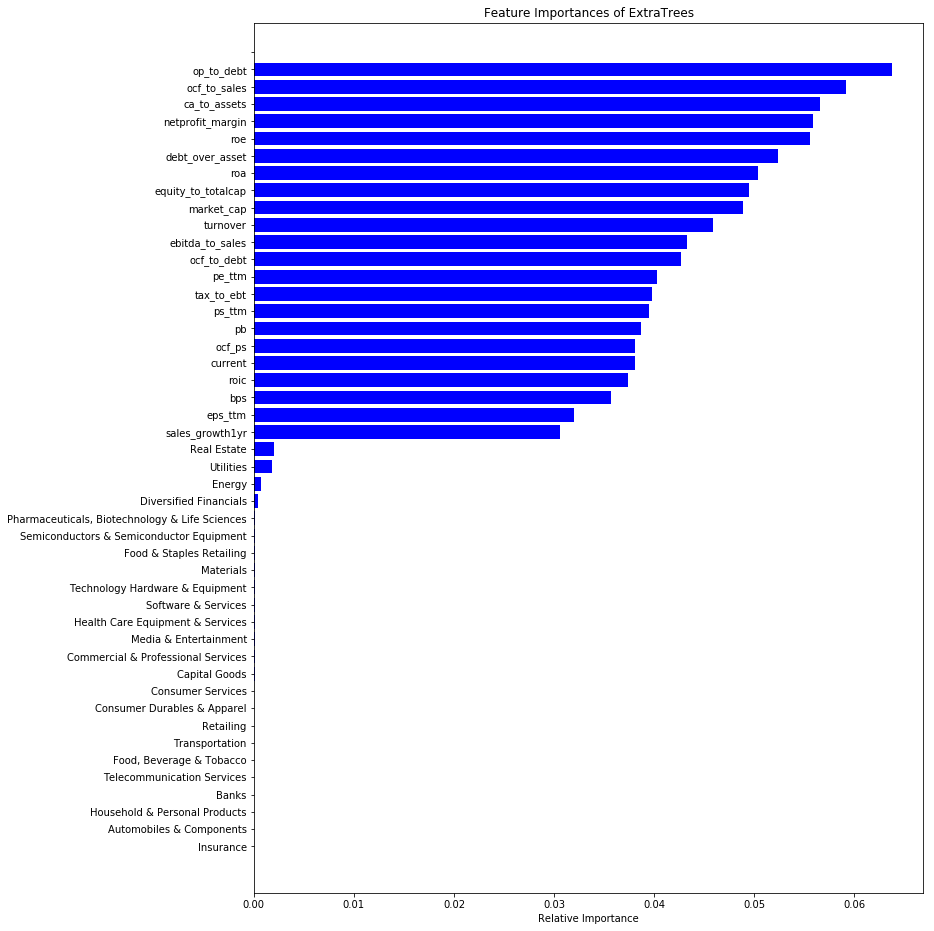

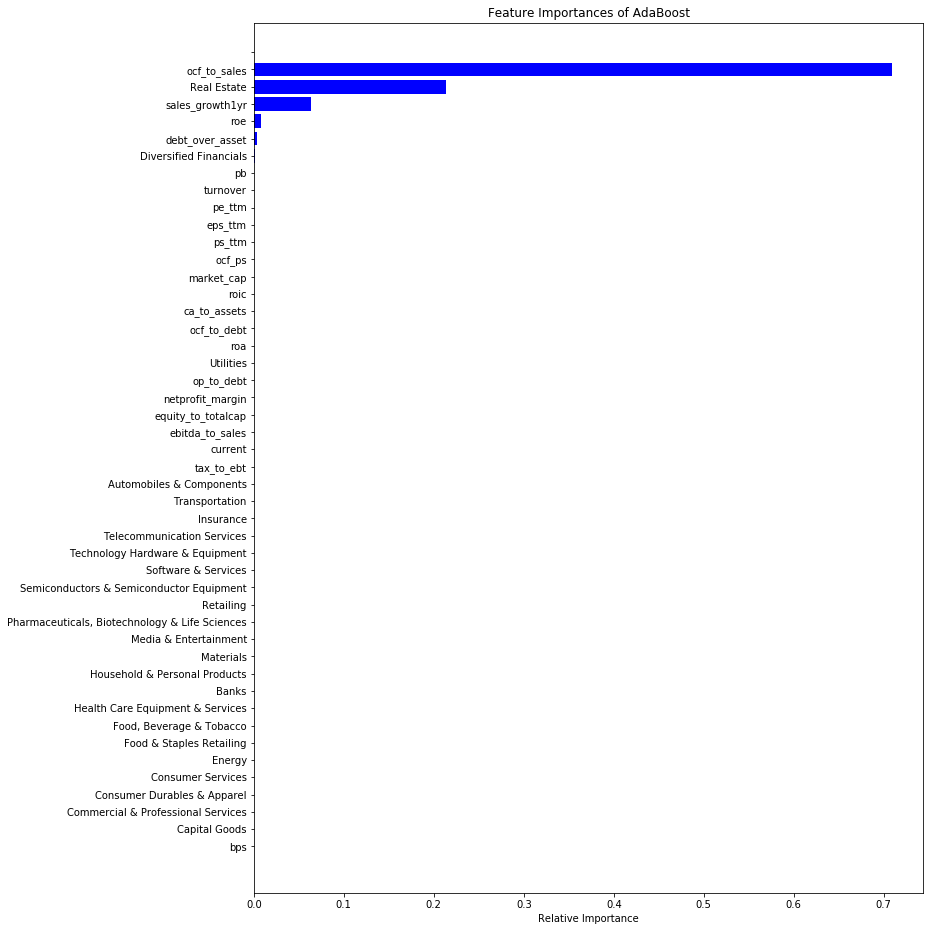

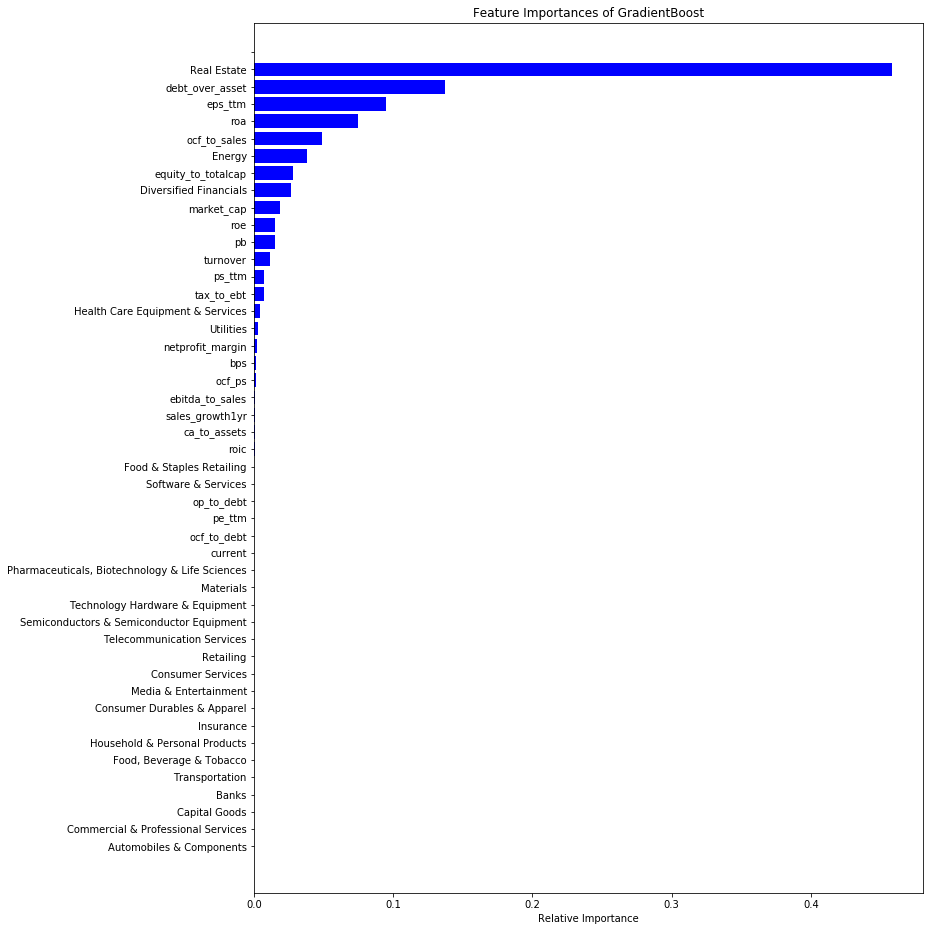

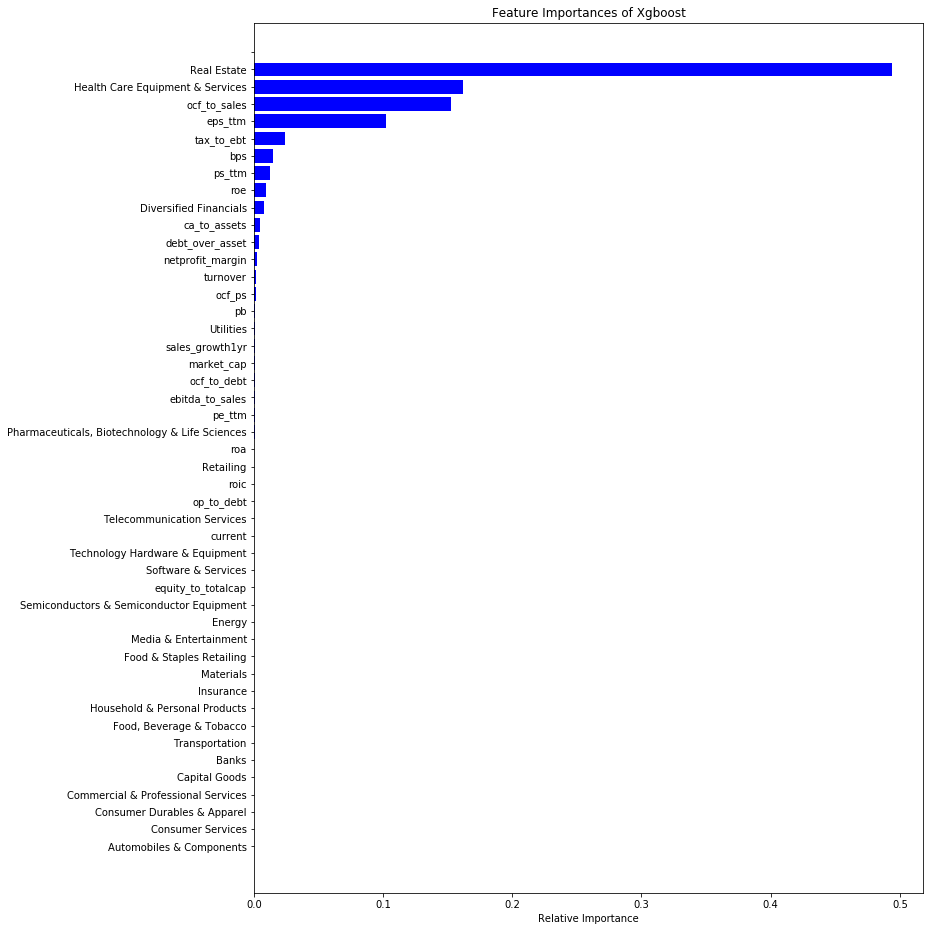

In [54]:
importance=best_rf_reg.feature_importances_
indices = np.argsort(importance)
# features= ["feature "+str(i) for i in range(47)]
features = X_train.columns.values
import matplotlib.pyplot as plt

for idx, m_ in enumerate(models):
    importance=m_.feature_importances_
    indices = np.argsort(importance)
    plt.figure(figsize=(12,16))
    plt.title('Feature Importances of '+ model_names[idx])
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(np.arange(47),labels=[features[i] for i in indices])
    plt.xlabel('Relative Importance')

Text(0.5, 0, 'Relative Importance')

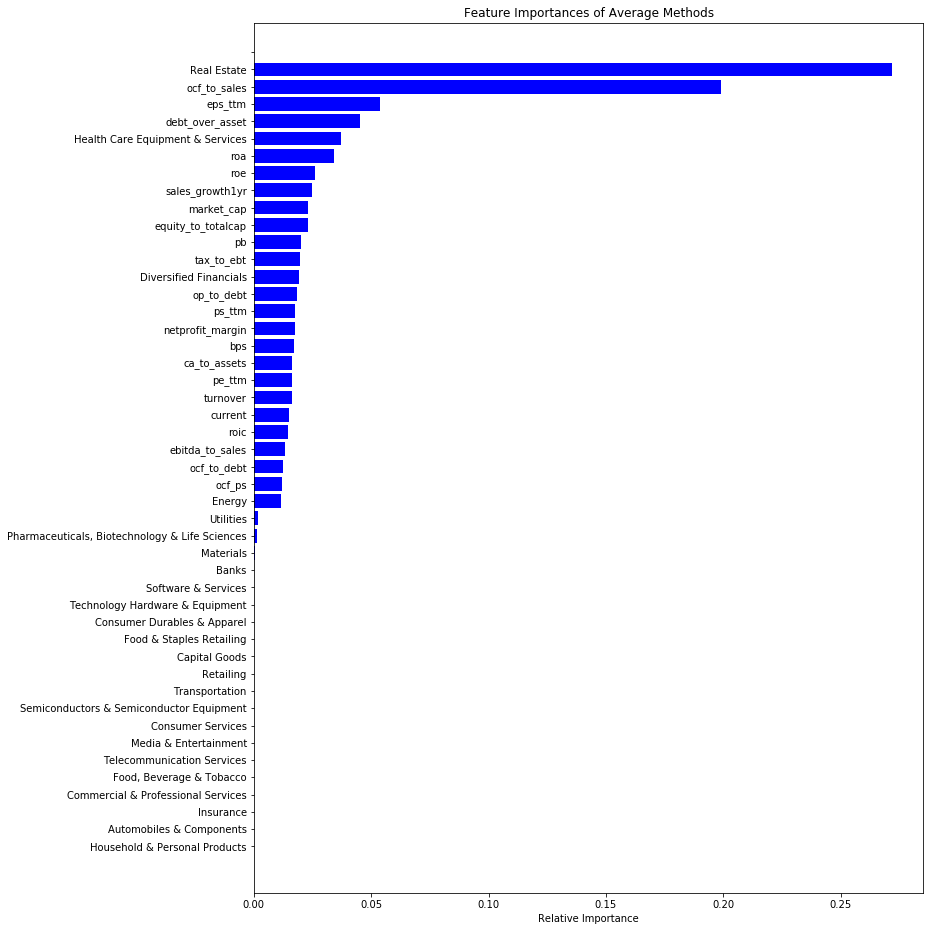

In [55]:
importance=importances.mean(axis=1)
indices = np.argsort(importance)
# features= ["feature "+str(i) for i in range(47)]
plt.figure(figsize=(12,16))
plt.title('Feature Importances of Average Methods')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(np.arange(47),labels=[features[i] for i in indices])
plt.xlabel('Relative Importance')

### 2.5 Neural Networks

#### 2.5.1 DNN for Return Predictions(Lanya MA)

In this part we attempt to built Neural Networks to predict equity returns.

In [56]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8598390160715947585
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930876211
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14556162337655784109
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [58]:
import tensorflow as tf
from tensorflow import keras

features_num = X_test.shape[1]

def reset_session(seed=42):
    tf.random.set_random_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

reset_session(seed=42)
model_dnn = keras.models.Sequential()    
model_dnn.add(keras.layers.Flatten(input_shape=[features_num]))
keras.layers.BatchNormalization()
for n_hidden in [125]*5:
    model_dnn.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
    keras.layers.BatchNormalization()
    model_dnn.add(keras.layers.Dropout(rate=0.2))
model_dnn.add(keras.layers.Dense(1)) 
optimizer = keras.optimizers.RMSprop(lr=0.005, rho=0.95,decay=1e-4)

model_dnn.compile(loss = 'mean_squared_error',
                  optimizer=optimizer,
                  metrics=["mse","mae"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_dnn.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
history1 = model_dnn.fit(X_train, y_train, epochs=100,
                         validation_data=(X_val, y_val),
                         callbacks=[checkpoint_cb, early_stopping_cb])

Instructions for updating:
Use tf.cast instead.
Train on 338023 samples, validate on 107540 samples
Epoch 1/100
338023/338023 [==============================] - 53s 157us/sample - loss: 7.7062 - mean_squared_error: 7.7062 - mean_absolute_error: 0.1451 - val_loss: 0.6651 - val_mean_squared_error: 0.6651 - val_mean_absolute_error: 0.1287
Epoch 2/100
338023/338023 [==============================] - 51s 152us/sample - loss: 7.6652 - mean_squared_error: 7.6652 - mean_absolute_error: 0.1184 - val_loss: 0.6662 - val_mean_squared_error: 0.6662 - val_mean_absolute_error: 0.1338
Epoch 3/100
338023/338023 [==============================] - 51s 151us/sample - loss: 7.6629 - mean_squared_error: 7.6629 - mean_absolute_error: 0.1113 - val_loss: 0.6595 - val_mean_squared_error: 0.6595 - val_mean_absolute_error: 0.0985
Epoch 4/100
338023/338023 [==============================] - 51s 152us/sample - loss: 7.6615 - mean_squared_error: 7.6615 - mean_absolute_error: 0.1093 - val_loss: 0.6607 - val_mean_squa

Epoch 34/100
338023/338023 [==============================] - 56s 165us/sample - loss: 7.6610 - mean_squared_error: 7.6610 - mean_absolute_error: 0.1042 - val_loss: 0.6612 - val_mean_squared_error: 0.6612 - val_mean_absolute_error: 0.1105
Epoch 35/100
338023/338023 [==============================] - 56s 167us/sample - loss: 7.6610 - mean_squared_error: 7.6610 - mean_absolute_error: 0.1042 - val_loss: 0.6596 - val_mean_squared_error: 0.6596 - val_mean_absolute_error: 0.0996
Epoch 36/100
338023/338023 [==============================] - 56s 165us/sample - loss: 7.6610 - mean_squared_error: 7.6609 - mean_absolute_error: 0.1042 - val_loss: 0.6600 - val_mean_squared_error: 0.6600 - val_mean_absolute_error: 0.1028
Epoch 37/100
338023/338023 [==============================] - 56s 166us/sample - loss: 7.6611 - mean_squared_error: 7.6611 - mean_absolute_error: 0.1041 - val_loss: 0.6594 - val_mean_squared_error: 0.6594 - val_mean_absolute_error: 0.0973
Epoch 38/100
338023/338023 [================

In [59]:
model_dnn.evaluate(X_test, y_test)

130137/130137 [==============================] - 7s 56us/sample - loss: 0.2011 - mean_squared_error: 0.2011 - mean_absolute_error: 0.1669


[0.20107144461999876, 0.2010717, 0.16693498]

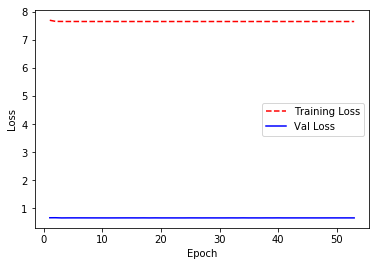

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Val Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_history(history1)

Why we have validation loss less than training loss? Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and weight regularization, are turned off at testing time.Besides, the training loss is the average of the losses over each batch of training data. Because model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

We can also observe that the in-sample MSE is much larger than MAE.We can say that the model fail to predict extremal values.This comes at no surprise as the data tend to be much noisy in Finance than in technology field like Computer Vision.  

#### 2.5.2  Feature Engineering in NN   (by Lanya MA)

In this part, we apply some field knowledge in Finance to feature engineering process, then we retrain our Neural Networks. 

In [61]:
from sklearn.linear_model import LinearRegression

def purifyFactor(raw_df):
    X_purified = copy.deepcopy(raw_df)
    X_purified = X_purified.drop(dummy_names,axis=1)
    X_purified = X_purified.drop(['market_cap'],axis=1)
    dummy_var = raw_df[dummy_names]
    X_reg = pd.concat([raw_df['market_cap'],dummy_var],axis=1)
    for col in X_purified.columns.values:
        reg = LinearRegression()
        Y_reg = X_purified[col]
        reg.fit(X_reg, Y_reg)
        Y_pred = reg.predict(X_reg)
        resid = Y_reg - Y_pred
        X_purified[col] = resid
    X_df = pd.concat([X_purified,raw_df['market_cap']],axis=1)
    X_df = pd.concat([X_df,raw_df[dummy_names]],axis=1)
    return X_df

In [62]:
X_P = {}
for time_key in time_keys[:-1]:
    X_P[time_key] = purifyFactor(X[time_key])

In [63]:
X_P_train = X_P[time_keys[0]]
y_train = y[time_keys[0]]
X_P_val = X_P[time_keys[80]]
y_val = y[time_keys[80]]
X_P_test = X_P[time_keys[100]]
y_test = y[time_keys[100]]
for time_key in time_keys[1:80]:
    X_P_train = pd.concat([X_P_train,X_P[time_key]])
    y_train = pd.concat([y_train,y[time_key]])
for time_key in time_keys[81:100]:   
    X_P_val = pd.concat([X_P_val,X_P[time_key]])
    y_val = pd.concat([y_val,y[time_key]])    
for time_key in time_keys[101:-1]:
    X_P_test = pd.concat([X_P_test,X_P[time_key]])
    y_test = pd.concat([y_test,y[time_key]])

Tune hyperparameter using skopt

In [64]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [65]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=2, high=7, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=50, high=500, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu','sigmoid','elu','selu'],
                             name='activation')
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]
default_parameters = [0.001, 5, 100, 'elu']
num_features = X_P_train.shape[1]

In [66]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = keras.models.Sequential()

    # Add an input layer
    model.add(keras.layers.Flatten(input_shape=[num_features]))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(keras.layers.Dense(num_dense_nodes,
                        activation=activation))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(keras.layers.Dense(1))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mae'])
    
    return model

In [67]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

In [68]:
# create subset of training samples
full_len = X_P_train.shape[0]
X_train1 = X_P_train[:round(0.1*full_len)]
y_train1 = y_train[:round(0.1*full_len)]
X_valid1 = X_P_val[:round(0.1*full_len)]
y_valid1 = y_val[:round(0.1*full_len)]

In [71]:
from tensorflow.python.keras.callbacks import TensorBoard
best_accuracy = 100
path_best_model = 'Model_A_tuned.keras'
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
    
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
   
    # Use Keras to train the model.
    history = model.fit(x=X_train1,
                        y=y_train1,
                        epochs=100,
                        verbose=0,
                        batch_size=128,
                        validation_data=(X_valid1, y_valid1),
                        callbacks=[callback_log,early_stopping_cb])

    
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['loss'][-1]

    # Print the classification accuracy.
    print()
    print("loss: {:.3f}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy < best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    tf.keras.backend.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return accuracy

In [72]:
fitness(x=default_parameters)

learning rate: 1.0e-03
num_dense_layers: 5
num_dense_nodes: 100
activation: elu


loss: 0.213



0.2132927882761992

In [73]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls= 50,
                            x0=default_parameters)

learning rate: 1.0e-03
num_dense_layers: 5
num_dense_nodes: 100
activation: elu


loss: 0.213

learning rate: 1.1e-03
num_dense_layers: 4
num_dense_nodes: 266
activation: elu


loss: 0.214

learning rate: 5.2e-03
num_dense_layers: 6
num_dense_nodes: 141
activation: selu


loss: 0.242

learning rate: 6.9e-04
num_dense_layers: 5
num_dense_nodes: 89
activation: sigmoid


loss: 0.225

learning rate: 1.3e-03
num_dense_layers: 3
num_dense_nodes: 74
activation: relu


loss: 0.205

learning rate: 3.0e-04
num_dense_layers: 5
num_dense_nodes: 450
activation: selu


loss: 0.214

learning rate: 5.8e-04
num_dense_layers: 6
num_dense_nodes: 246
activation: selu


loss: 0.212

learning rate: 1.4e-03
num_dense_layers: 3
num_dense_nodes: 145
activation: selu


loss: 0.215

learning rate: 4.5e-03
num_dense_layers: 6
num_dense_nodes: 189
activation: sigmoid


loss: 0.228

learning rate: 1.1e-04
num_dense_layers: 6
num_dense_nodes: 487
activation: selu


loss: 0.211

learning rate: 2.6e-03
num_dense_layer

In [76]:
search_result.x

[0.00011656126810820839, 7, 491, 'relu']

In [77]:
search_result.fun

0.18307862658414903

In [78]:
features_num = X_P_train.shape[1]

def reset_session(seed=42):
    tf.random.set_random_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

reset_session(seed=42)
model_dnn2 = keras.models.Sequential()    
model_dnn2.add(keras.layers.Flatten(input_shape=[features_num]))
keras.layers.BatchNormalization()
for n_hidden in [491]*7:
    model_dnn2.add(keras.layers.Dense(n_hidden, activation="relu", kernel_initializer="he_normal"))
    keras.layers.BatchNormalization()
    model_dnn2.add(keras.layers.Dropout(rate=0.1))
model_dnn2.add(keras.layers.Dense(1)) 
optimizer = keras.optimizers.Adam(lr=0.000116)

model_dnn2.compile(loss = 'mean_squared_error',
                   optimizer=optimizer,
                   metrics=["mse","mae"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_dnn2.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
history2 = model_dnn2.fit(X_P_train, y_train, epochs=100,
                          validation_data=(X_P_val, y_val),
                          callbacks=[checkpoint_cb, early_stopping_cb])

Train on 338023 samples, validate on 107540 samples
Epoch 1/100
338023/338023 [==============================] - 70s 207us/sample - loss: 7.7064 - mean_squared_error: 7.7064 - mean_absolute_error: 0.1341 - val_loss: 0.6615 - val_mean_squared_error: 0.6615 - val_mean_absolute_error: 0.1069
Epoch 2/100
338023/338023 [==============================] - 70s 206us/sample - loss: 7.6621 - mean_squared_error: 7.6620 - mean_absolute_error: 0.1059 - val_loss: 0.6599 - val_mean_squared_error: 0.6599 - val_mean_absolute_error: 0.1022
Epoch 3/100
338023/338023 [==============================] - 73s 216us/sample - loss: 7.6612 - mean_squared_error: 7.6612 - mean_absolute_error: 0.1047 - val_loss: 0.6601 - val_mean_squared_error: 0.6601 - val_mean_absolute_error: 0.1031
Epoch 4/100
338023/338023 [==============================] - 71s 211us/sample - loss: 7.6609 - mean_squared_error: 7.6609 - mean_absolute_error: 0.1044 - val_loss: 0.6597 - val_mean_squared_error: 0.6597 - val_mean_absolute_error: 0.1

In [79]:
model_dnn2.evaluate(X_P_test, y_test)

130137/130137 [==============================] - 7s 55us/sample - loss: 0.2044 - mean_squared_error: 0.2044 - mean_absolute_error: 0.1766


[0.20444409190536444, 0.20444421, 0.17662461]

#### 2.5.3 Neural Networks (Yiming Tan)

In [22]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

def reset_session(seed=42):
    tf.random.set_random_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()
reset_session()
MyDense = partial(keras.layers.Dense,
                  activation = "relu", kernel_initializer="normal"
                 ,kernel_regularizer = keras.regularizers.l1_l2(0.1, 0.01))
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[46]))
for n_hidden in (300, 100, 100, 50, 50, 50):
    model.add(MyDense(n_hidden))
model.add(keras.layers.Dense(1, name="Output"))

In [23]:
model.compile(loss="mean_squared_error",
              optimizer='adam',
              metrics=["mean_squared_error"])
model.save("First")

In [24]:
reset_session()
model = keras.models.load_model("First")
checkpoint_cb = keras.callbacks.ModelCheckpoint("First",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=200,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint_cb, early_stopping_cb])

Train on 338023 samples, validate on 107540 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
338023/338023 [==============================] - 55s 161us/sample - loss: 9.2192 - mean_squared_error: 7.6610 - val_loss: 1.4240 - val_mean_squared_error: 0.6606
Epoch 2/200
338023/338023 [==============================] - 54s 161us/sample - loss: 8.4330 - mean_squared_error: 7.6609 - val_loss: 1.4468 - val_mean_squared_error: 0.6603
Epoch 3/200
338023/338023 [==============================] - 54s 158us/sample - loss: 8.4568 - mean_squared_error: 7.6609 - val_loss: 1.4559 - val_mean_squared_error: 0.6608
Epoch 4/200
338023/338023 [==============================] - 54s 159us/sample - loss: 8.4587 - mean_squared_error: 7.6609 - val_loss: 1.4597 - val_mean_squared_error: 0.6597
Epoch 5/200
338023/338023 [==============================] - 54s 158us/sample - loss: 8.4589 - mean_squared_error: 7.6610 - val_loss: 1.4555 - val_mean_squared_error: 0.6609
Epoch 6/200
338023/338023 [===

In [25]:
from sklearn.metrics import mean_squared_error

ypred = model.predict(X_test)
mean_squared_error(y_test, ypred)

0.20839762408326715

### 2.6 Dimension Reduction (by Yiming Tan) 

In [28]:
y_labels = []
for time_key in time_keys[:-2]:
    y_copy = copy.deepcopy(y[time_key])
    y_sort = y[time_key].sort_values(by=['Excess_return'])
    ind = y_sort.index
    n = int(y_sort.shape[0]/5)
    y_label = y_copy.apply(lambda x : pd.cut(x,[y[time_key]['Excess_return'][ind[0]]-1,y[time_key]['Excess_return'][ind[n]],y[time_key]['Excess_return'][ind[2*n]],y[time_key]['Excess_return'][ind[3*n]],y[time_key]['Excess_return'][ind[4*n]],y[time_key]['Excess_return'][ind[-1]]],labels=[1,2,3,4,5]))
    if time_key in ('12/31/2008'):
        y_labels = y_label
    else:
        y_labels = pd.concat([y_labels,y_label])
y_label_val = np.concatenate(y_labels.values, axis=None)

In [30]:
X_full = X[time_keys[0]]
for time_key in time_keys[1:-2]:
    X_full = pd.concat([X_full,X[time_key]])

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_full)

Wall time: 2.53 s


In [32]:
y_label_val

array([5, 1, 3, ..., 5, 4, 1], dtype=int64)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
pca_tsne = Pipeline([
    ("pca", PCA(n_components=7, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

%time X_pcatsne_reduced = pca_tsne.fit_transform(X_full.iloc[:20000,:])

Wall time: 3min 22s


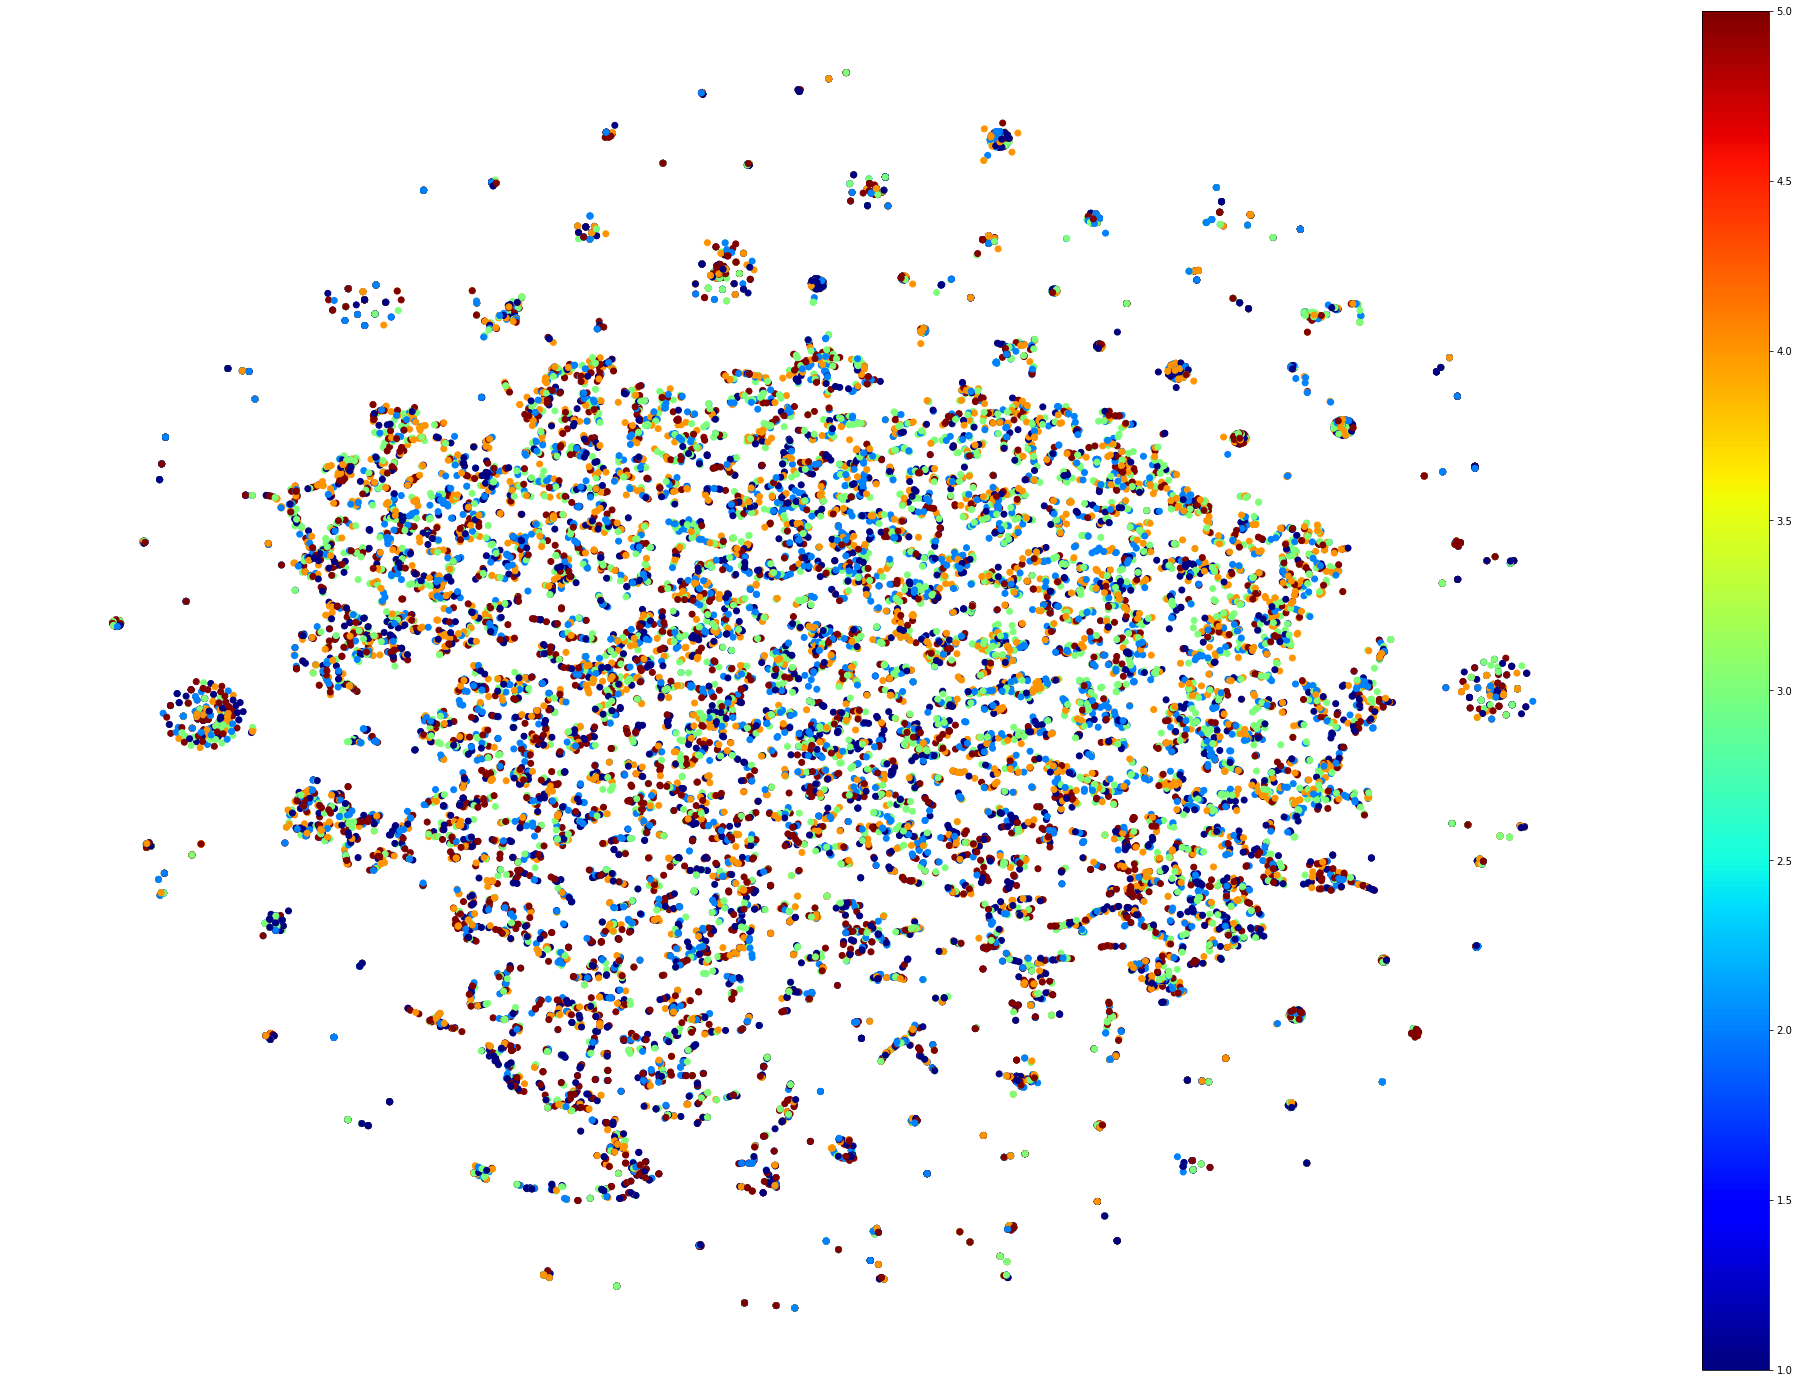

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#PCA with TSNE
plt.figure(figsize=(35,25))
plt.scatter(X_pcatsne_reduced[:, 0], X_pcatsne_reduced[:, 1], c=y_label_val[:20000], cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

## References

Gu, Shihao, Bryan Kelly, and Dacheng Xiu. *Empirical asset pricing via machine learning.* No. w25398. National Bureau of Economic Research, 2018.

